In [18]:
import polars as pl
import numpy as np
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# Récupérations des données

## Etape de scrapping (Facultative)

In [2]:
!python script_scrapping_dvf.py

/home/phdel/.pyenv/versions/3.10.6/lib/python3.10/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


Fetching data for year: 2019
File already exists: 01.csv.gz
File already exists: 02.csv.gz
File already exists: 03.csv.gz
File already exists: 04.csv.gz
File already exists: 05.csv.gz
File already exists: 06.csv.gz
File already exists: 07.csv.gz
File already exists: 08.csv.gz
File already exists: 09.csv.gz
File already exists: 10.csv.gz
File already exists: 11.csv.gz
File already exists: 12.csv.gz
File already exists: 13.csv.gz
File already exists: 14.csv.gz
File already exists: 15.csv.gz
File already exists: 16.csv.gz
File already exists: 17.csv.gz
File already exists: 18.csv.gz
File already exists: 19.csv.gz
File already exists: 21.csv.gz
File already exists: 22.csv.gz
File already exists: 23.csv.gz
File already exists: 24.csv.gz
File already exists: 25.csv.gz
File already exists: 26.csv.gz
File already exists: 27.csv.gz
File already exists: 28.csv.gz
File already exists: 29.csv.gz
File already exists: 2A.csv.gz
File already exists: 2B.csv.gz
File already exists: 30.csv.gz
File alrea

## Chargement dans un DataFrame

### Fonctions

In [3]:
def change_column_types(df):
    """
    Change les types de plusieurs colonnes dans un DataFrame Polars.

    Parameters:
        df (pl.DataFrame): Le DataFrame Polars.
        columns_dtypes (dict): Un dictionnaire où les clés sont les noms de colonnes
                               et les valeurs sont les nouveaux types (ex: pl.Int64, pl.Float64).

    Returns:
        pl.DataFrame: Un nouveau DataFrame avec les colonnes modifiées.
    """
    dict_type ={'id_mutation': pl.Utf8, 'date_mutation': pl.Date, 'numero_disposition': pl.Utf8, 'nature_mutation': pl.Utf8, 'valeur_fonciere': pl.Float64, 'adresse_numero' : pl.Utf8, 'adresse_suffixe': pl.Utf8, 'adresse_nom_voie': pl.Utf8, 'adresse_code_voie' : pl.Utf8, 'code_postal':pl.Utf8, 'code_commune':pl.Utf8, 'nom_commune':pl.Utf8, 'code_departement':pl.Utf8, 'ancien_code_commune':pl.Utf8, 'ancien_nom_commune':pl.Utf8, 'id_parcelle':pl.Utf8, 'ancien_id_parcelle':pl.Utf8, 'numero_volume':pl.Utf8, 'lot1_numero':pl.Utf8, 'lot1_surface_carrez':pl.Float64, 'lot2_numero':pl.Utf8, 'lot2_surface_carrez':pl.Float64, 'lot3_numero':pl.Utf8, 'lot3_surface_carrez':pl.Float64, 'lot4_numero':pl.Utf8, 'lot4_surface_carrez':pl.Float64, 'lot5_numero':pl.Utf8, 'lot5_surface_carrez':pl.Float64, 'nombre_lots':pl.Float64, 'code_type_local': pl.Utf8, 'type_local': pl.Utf8, 'surface_reelle_bati': pl.Float64, 'nombre_pieces_principales': pl.Float64, 'code_nature_culture':pl.Utf8, 'nature_culture':pl.Utf8, 'code_nature_culture_speciale':pl.Utf8, 'nature_culture_speciale':pl.Utf8, 'surface_terrain':pl.Float64, 'longitude':pl.Float64, 'latitude':pl.Float64}
    for column_name, column_type in dict_type.items():
        df = df.with_columns(pl.col(column_name).cast(column_type))
    return df

def data_loader(path, departements = [], annees = []):

    df = pl.DataFrame()
    if not annees:
        annees_list = os.listdir(path)
    else:
        annees_list =[str(annee) for annee in annees]
    for annee in annees_list:
        cur_year = os.path.join(path,annee)
        if not departements:
            departements_list = os.listdir(cur_year)
        else:
            departements_list = [f"{departement}.csv.gz" if departement>9 else f"0{departement}.csv.gz" for departement in departements]
        for departement in departements_list:
            file = os.path.join(cur_year,departement)
            temp_df = pl.read_csv(file,ignore_errors=True)
            temp_df = change_column_types(temp_df)
            df = pl.concat([df, temp_df])

    return df


## Chargement des données:

In [4]:
path = 'data_dvf'
df = data_loader(path,departements=[75,92,93,94])

In [5]:
df = df.filter(
    pl.col("valeur_fonciere").is_not_null() &
    pl.col("longitude").is_not_null() &
    pl.col("latitude").is_not_null() &
    (pl.col("surface_reelle_bati").is_not_nan() & pl.col("surface_terrain").is_not_nan())
)
df.head()

id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
str,date,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,f64,str,f64,str,f64,str,f64,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64
"""2023-1317178""",2023-01-06,"""1""","""Vente""",430000.0,"""118""","""B""","""RUE COMPANS""","""2252""","""75019""","""75119""","""Paris 19e Arrondissement""","""75""",null,null,"""75119000DH0124""",null,null,null,null,null,null,null,null,null,null,null,null,0.0,"""1""","""Maison""",18.0,1.0,"""S""","""sols""",null,null,28.0,2.389225,48.881102
"""2023-1317222""",2023-01-04,"""1""","""Vente en l'état futur d'achève…",7.62e8,"""12""",null,"""RUE DE CASTIGLIONE""","""1603""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AY0026""",null,null,null,null,null,null,null,null,null,null,null,null,0.0,"""4""","""Local industriel. commercial o…",89.0,0.0,"""S""","""sols""",null,null,454.0,2.328483,48.86607
"""2023-1317222""",2023-01-04,"""1""","""Vente en l'état futur d'achève…",7.62e8,"""12""",null,"""RUE DE CASTIGLIONE""","""1603""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AY0026""",null,null,null,null,null,null,null,null,null,null,null,null,0.0,"""4""","""Local industriel. commercial o…",8.0,0.0,"""S""","""sols""",null,null,454.0,2.328483,48.86607
"""2023-1317222""",2023-01-04,"""1""","""Vente en l'état futur d'achève…",7.62e8,"""12""",null,"""RUE DE CASTIGLIONE""","""1603""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AY0026""",null,null,null,null,null,null,null,null,null,null,null,null,0.0,"""4""","""Local industriel. commercial o…",14.0,0.0,"""S""","""sols""",null,null,454.0,2.328483,48.86607
"""2023-1317222""",2023-01-04,"""1""","""Vente en l'état futur d'achève…",7.62e8,"""12""",null,"""RUE DE CASTIGLIONE""","""1603""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AY0026""",null,null,null,null,null,null,null,null,null,null,null,null,0.0,"""4""","""Local industriel. commercial o…",109.0,0.0,"""S""","""sols""",null,null,454.0,2.328483,48.86607


## Prétraitement des données

In [6]:
data = df[['date_mutation','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain','longitude','latitude','valeur_fonciere']]

# # Calculer la composante saisonnière
data = data.with_columns([
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.sin(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("sin_month"),
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.cos(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("cos_month"),
    pl.col("date_mutation").dt.year().alias('year')
])

In [7]:
data.head(2)

date_mutation,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
date,str,f64,f64,str,f64,f64,f64,f64,f64,f64,i32
2023-01-06,"""Maison""",18.0,1.0,"""sols""",28.0,2.389225,48.881102,430000.0,0.5,0.866025,2023
2023-01-04,"""Local industriel. commercial o…",89.0,0.0,"""sols""",454.0,2.328483,48.86607,7.62e8,0.5,0.866025,2023


In [8]:
data.describe()

statistic,date_mutation,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""126881""","""126881""",126881.0,126881.0,"""126881""",126881.0,126881.0,126881.0,126881.0,126881.0,126881.0,126881.0
"""null_count""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2021-11-10 11:54:08.287000""",null,141.783876,2.890795,null,1776.743862,2.393283,48.85954,1.0684e7,-0.024632,0.059435,2021.311772
"""std""",null,null,840.270259,1.933328,null,5191.389788,0.10409,0.057533,3.6107e7,0.671488,0.738222,1.551478
"""min""","""2019-07-01""","""Appartement""",1.0,0.0,"""chemin de fer""",1.0,2.146007,48.688883,0.15,-1.0,-1.0,2019.0
"""25%""","""2020-07-22""",null,41.0,1.0,null,240.0,2.310964,48.815656,435000.0,-0.5,-0.866025,2020.0
"""50%""","""2021-10-25""",null,67.0,3.0,null,397.0,2.38978,48.867979,1.1e6,-2.4493e-16,6.1232e-17,2021.0
"""75%""","""2023-01-31""",null,102.0,4.0,null,800.0,2.485633,48.903054,7.02e6,0.5,0.866025,2023.0
"""max""","""2024-06-29""","""Maison""",100000.0,61.0,"""vergers""",116012.0,2.602515,48.986063,7.62e8,1.0,1.0,2024.0


In [9]:
from sklearn.model_selection import train_test_split
data_test = data.filter(pl.col('valeur_fonciere')<3e6)
y = data_test['valeur_fonciere']
X = data_test.drop(['valeur_fonciere'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
categorical_columns_onehot = ['nature_culture','type_local'] # Columns that need OneHotEncoding
numerical_columns = X.select(pl.col(pl.Float64)).columns # Numerical columns
# Encoding and imputer Pipeline
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute les valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot Encoding
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Remplit les NaN avec la moyenne
    ('scaler', StandardScaler())                 # Standardisation
])

# Encoding pipeline

column_transformer =  ColumnTransformer(
    transformers=[
        ('onehot', onehot_pipeline, categorical_columns_onehot),
        ('numeric', numeric_pipeline, numerical_columns)
    ]
)

In [11]:
from sklearn import set_config

# Configuration pour afficher graphiquement
set_config(display="diagram")

# Afficher la pipeline dans un notebook
display(column_transformer)


ColumnTransformer(transformers=[('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['nature_culture', 'type_local']),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['surface_reelle_bati',
                                  'nombre_pieces_principales',
                                  'surface_terrain', 'longitude', 'latitude',
                                  'sin_month', 'cos_month'])])

In [12]:
model = LinearRegression()

LR_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('linear_model',model)
])
display(LR_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('linear_model', LinearRegression())])

In [13]:
LR_pipeline.fit(X_train,y_train)
y_pred = LR_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')

 R² = 0.2432287692321754


In [14]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

lgb_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('linear_model',model)
])
display(lgb_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('linear_model', LGBMRegressor(random_state=42))])

In [15]:
lgb_pipeline.fit(X_train,y_train)
y_pred = lgb_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 64592, number of used features: 15
[LightGBM] [Info] Start training from score 758869.566513
 R² = 0.682509294929238


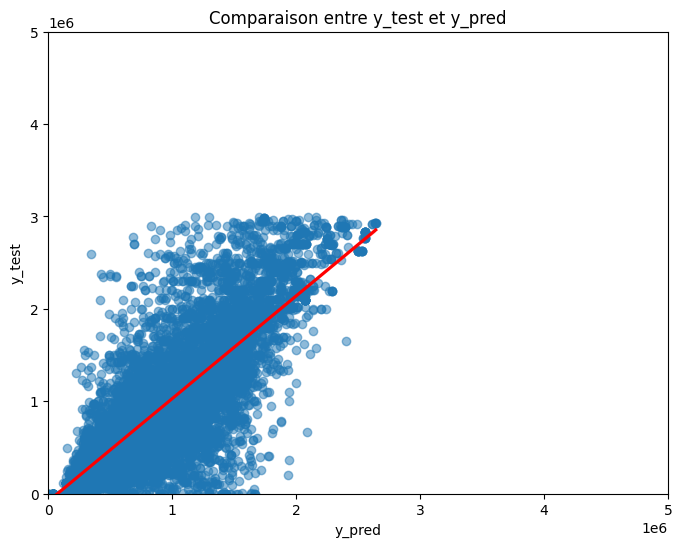

In [16]:
validation = pl.DataFrame()
validation = pl.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Tracer avec seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,5e6)
plt.ylim(0,5e6)
plt.title("Comparaison entre y_test et y_pred")
plt.show()


In [26]:
class ToNumpyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Si X est un DataFrame ou une série Polars, le convertir en NumPy array
        if isinstance(X, (pl.DataFrame, pl.Series)):
            return X.to_numpy()
        return X

model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE')
catboost_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('to_numpy',ToNumpyTransformer()),
    ('catboost_model',model)
])
display(catboost_pipeline)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('to_numpy', ToNumpyTransformer()),
                ('catboost_model',
                 <catboost.core.CatBoostRegressor object at 0x7f2f71ac8d60>)])

In [27]:
catboost_pipeline.fit(X_train,y_train)
y_pred = catboost_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')
validation = pl.DataFrame()
validation = pl.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Tracer avec seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,5e6)
plt.ylim(0,5e6)
plt.title("Comparaison entre y_test et y_pred")
plt.show()


CatBoostError: Invalid label type=<class 'polars.series.series.Series'>: must be array like.

In [16]:
# dict_type ={'id_mutation': pl.Utf8, 'date_mutation': pl.Date, 'numero_disposition': pl.Utf8, 'nature_mutation': pl.Utf8, 'valeur_fonciere': pl.Float64, 'adresse_numero' : pl.Utf8, 'adresse_suffixe': pl.Utf8, 'adresse_nom_voie': pl.Utf8, 'adresse_code_voie' : pl.Utf8, 'code_postal':pl.Utf8, 'code_commune':pl.Utf8, 'nom_commune':pl.Utf8, 'code_departement':pl.Utf8, 'ancien_code_commune':pl.Utf8, 'ancien_nom_commune':pl.Utf8, 'id_parcelle':pl.Utf8, 'ancien_id_parcelle':pl.Utf8, 'numero_volume':pl.Utf8, 'lot1_numero':pl.Utf8, 'lot1_surface_carrez':pl.Float64, 'lot2_numero':pl.Float64, 'lot2_surface_carrez':pl.Float64, 'lot3_numero':pl.Float64, 'lot3_surface_carrez':pl.Float64, 'lot4_numero':pl.Float64, 'lot4_surface_carrez':pl.Float64, 'lot5_numero':pl.Float64, 'lot5_surface_carrez':pl.Float64, 'nombre_lots':pl.Float64, 'code_type_local': pl.Utf8, 'type_local': pl.Utf8, 'surface_reelle_bati': pl.Float64, 'nombre_pieces_principales': pl.Float64, 'code_nature_culture':pl.Utf8, 'nature_culture':pl.Utf8, 'code_nature_culture_speciale':pl.Utf8, 'nature_culture_speciale':pl.Utf8, 'surface_terrain':pl.Float64, 'longitude':pl.Float64, 'latitude':pl.Float64}